# CNN

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install hurst==0.0.5
  %pip install imbalanced_learn==0.12.3
  %pip install imblearn==0.0
  %pip install protobuf==5.27.0
  %pip install pykalman==0.9.7
  %pip install tqdm==4.66.4

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/intra-day-agriculture-futures-trades-2023-2024"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


In [3]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        strategy = tf.distribute.MirroredStrategy()
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-06-01 10:52:28.094538: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 10:52:28.167468: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 10:52:28.167518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 10:52:28.173376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 10:52:28.202058: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: [2.15.1]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
1 Physical GPUs, 1 Logical GPUs
Physical devices cannot be modified after being initialized
Running on 1 GPU(s)
Number of accelerators: 1


2024-06-01 10:52:30.385348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 10:52:30.552033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 10:52:30.552072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 10:52:30.558508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 10:52:30.558615: I external/local_xla/xla/stream_executor

'/mnt/c/Users/adamd/workspace/intra_day_futures_arb'

# Instruments

## Data Load

In [4]:
import pandas as pd
import numpy as np
from algo_trading_utility_script import *

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)

HALF_LIFE, HURST = get_ou(futs_df, f'{TARGET_FUT}_Close')

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

futs_df.head(2)

./data//futures_15m.csv
(4688, 128)
Half-Life: 402
Hurst: 0.4924908823368793


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 15:30:00+00:00,3.587,3.587,3.574,3.580,191.0,55.0,3.579749,0.013,4.167,4.179,...,1188.444270,9.25,600.5,605.0,600.00,604.5,7203.0,2296.0,602.673732,5.00
2023-06-01 15:45:00+00:00,3.583,3.588,3.581,3.583,42.0,22.0,3.584048,0.007,4.173,4.173,...,1191.678377,3.00,604.5,607.5,602.75,605.0,4481.0,1411.0,605.502724,4.75


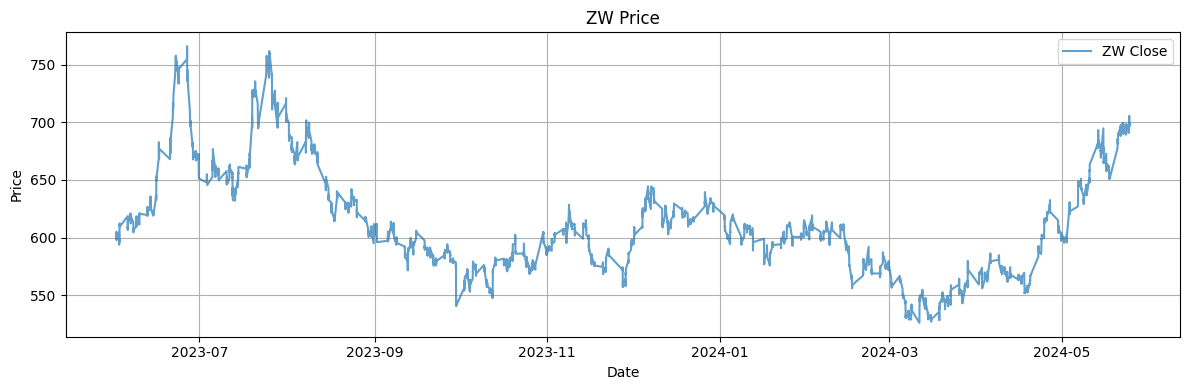

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [6]:
import pickle
from tqdm import tqdm

from sklearn.preprocessing import normalize

TEST_SPLIT = 0.8
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)
CACHE = True
FUTURES_TMP_FILE = "./tmp/futures.pkl"
os.makedirs("./tmp/", exist_ok=True)

def oversample_mean_reversions(train_agri_ts, window, period=INTERVAL, hurst=HURST):
    samples = []
    for df in tqdm(train_agri_ts, desc="oversample_mean_reversions"):
        bb_df = df.copy()
        results_df = param_search_bbs(bb_df, StockFeatExt.CLOSE, period, initial_window=window * 2, window_min=window // 2, hurst=hurst)
        results_df = results_df[results_df["Metric"] == "Sharpe"]
        bb_df, _ = bollinger_band_backtest(bb_df, StockFeatExt.CLOSE, results_df["Window"].iloc[0], period, std_factor=results_df["Standard_Factor"].iloc[0])

        samples.append(bb_df[train_agri_ts[0].columns].reset_index(drop=True))
    return train_agri_ts + samples

def normalize_and_label_data(ts, meta_label=META_LABEL, cols_to_scale=COLS_TO_SCALE):
    y0 = 0
    y1 = 0
    process_data = []
    for df in tqdm(ts, desc="label_data"):
        df = aug_metalabel_mr(df)
        y0  += (df[meta_label] == 0).sum()
        y1  += (df[meta_label] > 0).sum()

        if cols_to_scale is not None:
            aug_df_scaled = normalize(df[cols_to_scale])
            aug_df_scaled = pd.DataFrame(aug_df_scaled, columns=cols_to_scale)
            df[cols_to_scale] = aug_df_scaled
            df = df.loc[:, ~df.columns.duplicated(keep="first")]

        process_data.append(df)

    total = y0 + y1
    class_weight_0 = total / y0 if y0 != 0 else 0
    class_weight_1 = total / y1 if y1 != 0 else 0
    class_weights = {0: class_weight_0, 1: class_weight_1}

    return process_data, class_weights

with strategy.scope():
    if not os.path.exists(FUTURES_TMP_FILE):
        futs_exog_df = process_exog(MARKET_FUTS, futs_df)
        train_agri_ts, val_agri_ts = process_futures(FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
        # train_agri_ts = oversample_mean_reversions(train_agri_ts, HALF_LIFE)
        # val_agri_ts = oversample_mean_reversions(val_agri_ts, HALF_LIFE)

        if CACHE:
            with open(FUTURES_TMP_FILE, 'wb') as f:
                pickle.dump((train_agri_ts, val_agri_ts), f)
    else:
        with open(FUTURES_TMP_FILE, 'rb') as f:
            train_agri_ts, val_agri_ts = pickle.load(f)

train_agri_ts, CLASS_WEIGHTS = normalize_and_label_data(train_agri_ts)
val_agri_ts, val_weights = normalize_and_label_data(val_agri_ts)

print(f"train: {CLASS_WEIGHTS}")
print(f"test: {val_weights}")
np.shape(train_agri_ts)

label_data: 100%|██████████| 16/16 [00:00<00:00, 61.81it/s]

train: {0: 1.038026365869693, 1: 27.2975432211101}
test: {0: 1.0547473469674609, 1: 19.265725288831835}


(16, 3750, 92)

In [7]:
FEATURES = KF_COLS + BB_COLS + MOM_COLS + StockFeatExt.list

sample = val_agri_ts[0]
print(sample[META_LABEL].value_counts())

sampled_pattenrs = sample[sample[META_LABEL] > 0]
sampled_pattenrs[FEATURES + [META_LABEL, "Ret"]].tail(10)

mr_label
0    870
1     68
Name: count, dtype: int64


,SD,Z1,Z2,Filtered_X,KG_X,KG_Z1,KG_Z2,MA,U,L,...,Open,High,Low,Close,Volume,Spread,Barcount,Average,mr_label,Ret
889,0.000350,-0.000021,-0.000006,0.000158,0.000121,0.000084,0.000025,0.122043,0.122751,0.121335,...,0.122282,0.122415,0.122017,0.122150,0.910353,0.000398,0.147747,0.122262,1,0.000000
890,0.000280,-0.000037,-0.000010,0.000083,0.000094,0.000067,0.000021,0.095186,0.095752,0.094620,...,0.095309,0.095309,0.094947,0.095050,0.942950,0.000362,0.141774,0.095144,1,0.003256
900,0.000099,0.000026,0.000009,0.000068,0.000030,0.000022,0.000007,0.030192,0.030392,0.029992,...,0.030252,0.030465,0.030252,0.030465,0.987602,0.000212,0.124405,0.030378,1,0.000000
901,0.000207,0.000021,0.000003,0.000136,0.000057,0.000044,0.000014,0.062040,0.062459,0.061621,...,0.062502,0.062502,0.062334,0.062334,0.971473,0.000168,0.132443,0.062404,1,0.000000
902,0.000204,0.000005,-0.000003,0.000128,0.000059,0.000042,0.000013,0.060171,0.060584,0.059757,...,0.060408,0.060635,0.060408,0.060538,0.970167,0.000227,0.149706,0.060528,1,0.000000
903,0.000195,-0.000019,-0.000009,0.000094,0.000056,0.000041,0.000013,0.056443,0.056838,0.056048,...,0.056749,0.056870,0.056597,0.056627,0.974800,0.000274,0.133398,0.056755,1,0.000000
904,0.000233,-0.000010,-0.000004,0.000116,0.000066,0.000050,0.000016,0.067824,0.068295,0.067353,...,0.067926,0.068218,0.067743,0.068145,0.963959,0.000475,0.157324,0.067955,1,0.000000
905,0.000280,-0.000022,-0.000006,0.000123,0.000082,0.000061,0.000020,0.084034,0.084601,0.083468,...,0.084368,0.084413,0.084051,0.084232,0.949840,0.000362,0.164757,0.084264,1,0.000000
906,0.000386,-0.000037,-0.000008,0.000152,0.000119,0.000088,0.000028,0.125424,0.126206,0.124643,...,0.125601,0.125803,0.125533,0.125533,0.907131,0.000270,0.141115,0.125675,1,0.000000
907,0.000278,-0.000027,-0.000004,0.000086,0.000088,0.000063,0.000020,0.089726,0.090289,0.089162,...,0.089818,0.089867,0.089625,0.089674,0.949825,0.000241,0.132242,0.089765,1,0.004287


In [8]:
WINDOW = 511  # window is the k+k-1xd-1 or the sum i=0..n of 1+sum(receptive feild)x2^i
WINDOW_TMP_PATH = "./tmp/"
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = 8  * strategy.num_replicas_in_sync # Default 8
print(f"BATCH_SIZE: {BATCH_SIZE}")

def prepare_windows(data_df, label_df, window_size=WINDOW):
    """
    Prepare windows of features and corresponding labels for classification.
    IMPORTANT: There is no padding, incomplete timewindows are discarded!

    Parameters:
    - data_df: DataFrame containing the features.
    - label_df: DataFrame containing the labels.
    - window_size: The size of the input window.

    Returns:
    - X: Array of input windows.
    - y: Array of corresponding labels.
    """
    X, y = [], []
    for i in range(len(data_df) - window_size):
        input_window = data_df.iloc[i : i + window_size].values
        assert not np.isnan(input_window).any(), "NaN values found in input window"
        X.append(input_window)
        if label_df is not None:
            target_label = label_df.iloc[i + window_size]
            y.append([target_label])
            assert not np.isnan(target_label).any(), "NaN values found in target label"
    return np.array(X), np.array(y)

def prepare_window_with_disjoint_ts(ts_list, window_size=WINDOW):
    """
    Generator function to yield windows of features and corresponding labels from multiple time series.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.

    Yields:
    - features: The input window of features.
    - labels: The corresponding label.
    """
    for data_df in ts_list:
        X, y = prepare_windows(data_df[FEATURES], data_df[META_LABEL], window_size=window_size)
        for features, labels in zip(X, y):
            yield features, labels

def create_windowed_dataset_from_generator(ts_list, window_size=WINDOW, batch_size=BATCH_SIZE):
    """
    Create a TensorFlow dataset from a generator.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.
    - batch_size: The batch size for the dataset.

    Returns:
    - dataset: A TensorFlow dataset.
    """
    dataset = tf.data.Dataset.from_generator(
        lambda: prepare_windows_with_disjoint_ts(ts_list, window_size=window_size),
        output_signature=(
            tf.TensorSpec(shape=(window_size, len(FEATURES)), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.float32)  # Assuming labels are floats for binary classification
        )
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def create_dataset_from_generator(ts_list, batch_size):
    def generator(ts_list):
        full_df = pd.concat(ts_list)
        for i, row in full_df.iterrows():
            yield row[FEATURES].values, row[META_LABEL]  # Reshape to match (1,)

    output_signature = (
        tf.TensorSpec(shape=(len(FEATURES),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        lambda: generator(ts_list),
        output_signature=output_signature
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

with strategy.scope():
    train_dataset = create_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
    val_dataset = create_dataset_from_generator(val_agri_ts, batch_size=BATCH_SIZE)

BATCH_SIZE: 8


In [9]:
# INPUT_SHAPE = (len(FEATURES), ) # The expected shape, where the None shape is BATCH_SIZE

sampled_dataset = val_dataset.shuffle(buffer_size=250).take(1)
for features, labels in train_dataset.take(1):
    INPUT_SHAPE = features.numpy().shape[1:]  # Assuming the shape is (batch_size, len(FEATURES))
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

print("INPUT_SHAPE:", INPUT_SHAPE)

Features: [[1.3377445e-04 6.0373914e-06 6.1773665e-07 5.9513997e-05 3.8769591e-05
  1.2254742e-05 1.8859463e-06 5.3837184e-02 5.4100491e-02 5.3573877e-02
  0.0000000e+00 0.0000000e+00 5.3993553e-02 5.3993553e-02 5.3699575e-02
  5.3871062e-02 9.6012491e-01 2.9397578e-04 2.2136377e-01 5.3858176e-02]
 [2.9245103e-04 1.0615920e-05 1.0862046e-06 1.0464715e-04 6.8170979e-05
  2.1548272e-05 3.3161764e-06 9.4616413e-02 9.5192045e-02 9.4040789e-02
  0.0000000e+00 0.0000000e+00 9.4767906e-02 9.4897136e-02 9.4164841e-02
  9.4466373e-02 9.2286712e-01 7.3229743e-04 2.4157201e-01 9.4556808e-02]
 [3.5650274e-04 1.2135955e-05 1.2417324e-06 1.1963101e-04 7.7932011e-05
  2.4633651e-05 3.7910017e-06 1.0820401e-01 1.0890571e-01 1.0750231e-01
  0.0000000e+00 0.0000000e+00 1.0804174e-01 1.0843570e-01 1.0799250e-01
  1.0828797e-01 9.1318417e-01 4.4319767e-04 2.2002302e-01 1.0823511e-01]
 [2.7195780e-04 8.5000411e-06 8.6971124e-07 8.3789739e-05 5.4583696e-05
  1.7253446e-05 2.6552232e-06 7.5836837e-02 7.63721

# CNN Architecture

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Add, Multiply, Input, Flatten, Dense, AveragePooling1D, MaxPooling1D, SpatialDropout1D, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2, l1, l1_l2

MODEL_NAME = "WAVENET"
MAX_DILATION = 8
DILATION_RATE = 1
EPOCHS = 10
PATIENCE_EPOCHS = 3
FILTERS = 32
DROPRATE = 0.4
KERNEL_SIZE = 3
REG_WEIGHTS = 0.01
CONVOLUTIONS = 10
LEARN_RATTE =1e-3
DENSE_SIZE = 32

def wavenet_block(inputs, layer_id, filters, kernel_size=KERNEL_SIZE,
                  dilation_rate=DILATION_RATE, reg_param=REG_WEIGHTS, dropout_rate=DROPRATE):
    # Filter = is the output, kernel is the input or scope.
    # Dilation expands the receptive field of the kernel.
    conv_f = Conv1D(filters, kernel_size,
                    dilation_rate=dilation_rate,
                    padding='causal',
                    kernel_regularizer=l2(reg_param),
                    name=f'conv_f_{layer_id}')(inputs)
    conv_g = Conv1D(filters, kernel_size,
                    dilation_rate=dilation_rate,
                    padding='causal',
                    kernel_regularizer=l2(reg_param),
                    name=f'conv_g_{layer_id}')(inputs)
    tanh_out = Activation('tanh')(conv_f)
    sigmoid_out = Activation('sigmoid')(conv_g)
    merged = Multiply()([tanh_out, sigmoid_out])
    # merged = SpatialDropout1D(dropout_rate)(merged)

    skip_out = Conv1D(filters, 1, padding='same',
                      kernel_regularizer=l2(reg_param),
                      name=f'skip_{layer_id}')(merged)
    residual_out = Conv1D(filters, 1, padding='same',
                          kernel_regularizer=l2(reg_param),
                          name=f'residual_{layer_id}')(inputs)
    residual_out = Add()([residual_out, skip_out])

    return residual_out, skip_out


def build_wavenet_model(input_shape, filters=FILTERS, kernel_size=KERNEL_SIZE,
                        reg_param=REG_WEIGHTS, dropout_rate=DROPRATE, convolutions=CONVOLUTIONS,
                        max_dilation=MAX_DILATION):
    inputs = Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for i in range(convolutions):
        dilation_rate = min(2 ** i, max_dilation)
        x, skip = wavenet_block(x, layer_id=i,
                                filters=filters,
                                kernel_size=kernel_size,
                                dilation_rate=dilation_rate,
                                reg_param=reg_param,
                                dropout_rate=dropout_rate)
        skip_connections.append(skip)

    x = Add()(skip_connections)
    x = Activation('relu')(x)

    # Downsample the output to coarser frames
    x = AveragePooling1D(pool_size=2)(x)

    x = Conv1D(filters, 1, activation='relu', kernel_regularizer=l2(reg_param), name='post_conv_1')(x)
    x = Conv1D(filters, 1, activation='relu', kernel_regularizer=l2(reg_param), name='post_conv_2')(x)
    x = Flatten()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(reg_param), name='fc1')(x)
    x = Dropout(dropout_rate, name='fcdo1')(x)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_param), name='output_dense')(x)

    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

def build_baseline_model(input_shape,
                         filters=FILTERS,
                         kernel_size=KERNEL_SIZE,
                        reg_param=REG_WEIGHTS,
                        dropout_rate=DROPRATE,
                        convolutions=CONVOLUTIONS,
                        max_dilation=MAX_DILATION):
    inputs = Input(shape=input_shape)

    x = Dense(DENSE_SIZE, activation='relu', kernel_regularizer=l1_l2(reg_param))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(DENSE_SIZE, activation='relu', kernel_regularizer=l1_l2(reg_param))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid', name='output_dense', kernel_regularizer=l1_l2(reg_param))(x)

    return Model(inputs, outputs, name=f'{MODEL_NAME}_BASELINE')

## Training

In [26]:
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import shutil
import json

MODEL_DIR = f"models/{MODEL_NAME}"
IMAGES_DIR = f"images/{MODEL_NAME}/images"
LOG_BASEPATH = f"logs/{MODEL_NAME}/tb"
TARGET_METRIC = "val_auc"
PURGE = False

if not PURGE:
    # Remove tensorboard logs and other training artefacts for a fresh loop.
    shutil.rmtree(LOG_BASEPATH, ignore_errors=True)
    shutil.rmtree(MODEL_DIR, ignore_errors=True)
    shutil.rmtree(IMAGES_DIR, ignore_errors=True)

def build_cnn(input_shape, train_dataset, test_dataset=None, lr=LEARN_RATTE):
    model = build_baseline_model(
        input_shape=input_shape,
        filters=FILTERS,
        kernel_size=KERNEL_SIZE,
        reg_param=REG_WEIGHTS,
        dropout_rate=DROPRATE,
        convolutions=CONVOLUTIONS,
    )

    optimizer = Adam(learning_rate=lr)
    loss = BinaryCrossentropy(from_logits=False,
                              reduction='sum_over_batch_size',
                              name='bce')
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[BinaryAccuracy(name='ba'), AUC(name='auc')]
    )
    callbacks = [
        EarlyStopping(
            patience=PATIENCE_EPOCHS,
            monitor=TARGET_METRIC,
            restore_best_weights=True,
        ),
        ReduceLROnPlateau(
            monitor=TARGET_METRIC,
            factor=0.5,
            patience=2,
            verbose=1,
            min_lr=1e-5
        ),
        TensorBoard(
            log_dir=LOG_BASEPATH,
            histogram_freq=1,
            write_images=True
        )
    ]

    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

history = None
with strategy.scope():
    if not PURGE and os.path.exists(MODEL_PATH):
        print(f"Loading model from: {MODEL_PATH}")
        model = tf.keras.models.load_model(MODEL_PATH)
        if os.path.exists(f"{MODEL_PATH}\history.json"):
            with open(f"{MODEL_PATH}\history.json", 'r') as f:
                history = json.load(f)
    else:
        print(f"input_shape: {INPUT_SHAPE}")
        model, history = build_cnn(INPUT_SHAPE, train_dataset=train_dataset, test_dataset=val_dataset)
        model.save(MODEL_PATH)
        with open(f"{MODEL_PATH}\history.json", 'w') as f:
            json.dump(history.history, f)
model.summary()

Loading model from: ./models
Model: "WAVENET_BASELINE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 output_dense (Dense)        (None, 1)                 33        
                                                                 
Total params: 1761 (6

### Visualize Outputs

In [27]:
if history is not None:
    # Model might have been loaded from storage.
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['ba'], label='Train Accuracy')
    plt.plot(history.history['val_ba'], label='Val Accuracy')
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('Model Accuracy and AUC')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Explain

In [28]:
import shap
shap.initjs()

RANDOMIZE_SIZE = 32
SAMPLE_SIZE = 100

train_dataset = create_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
sampled_dataset = train_dataset.shuffle(buffer_size=RANDOMIZE_SIZE*SAMPLE_SIZE).take(SAMPLE_SIZE)
sampled_dataset = list(sampled_dataset.as_numpy_iterator())

test_dataset = create_dataset_from_generator(train_agri_ts, batch_size=BATCH_SIZE)
sampled_testdataset = test_dataset.shuffle(buffer_size=RANDOMIZE_SIZE*SAMPLE_SIZE).take(SAMPLE_SIZE)
sampled_testdataset = list(sampled_testdataset.as_numpy_iterator())

background_features = np.concatenate([batch[0] for batch in sampled_dataset], axis=0)
background = background_features[np.random.choice(background_features.shape[0], SAMPLE_SIZE, replace=False)]

test_features = np.concatenate([batch[0] for batch in sampled_testdataset], axis=0)
test_labels = np.concatenate([batch[1] for batch in sampled_testdataset], axis=0)

2024-06-01 10:56:38.197713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 2485 of 3200
2024-06-01 10:56:41.149160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-06-01 10:56:51.608936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:41: Filling up shuffle buffer (this may take a while): 2432 of 3200
2024-06-01 10:56:54.640165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


SHAP values shape: (800, 20)
Test features shape: (800, 20)


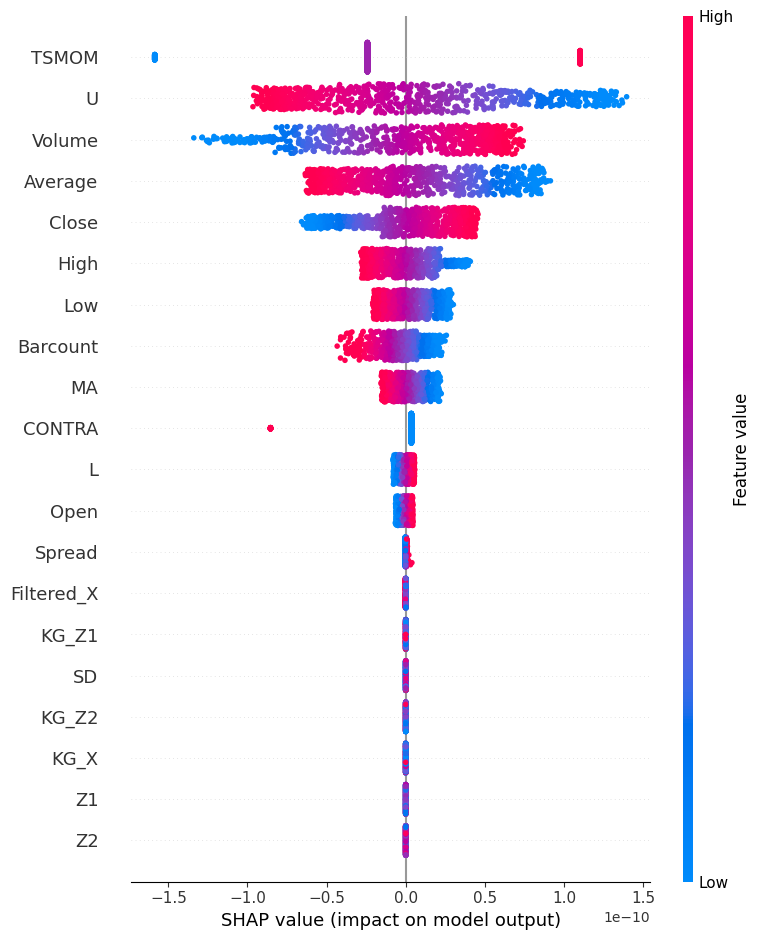

In [29]:
e = shap.DeepExplainer(model, background)

shap_values = e.shap_values(test_features)
if isinstance(shap_values, list):
    shap_values = shap_values[0]
shap_values = np.squeeze(shap_values)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Test features shape: {test_features.shape}")
assert shap_values.shape == test_features.shape
shap.summary_plot(shap_values, test_features, feature_names=FEATURES)

  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values shape: (20, 20, 1)
Misclassified: (20,) out of 20
Explainer expected value: [0.01022588]


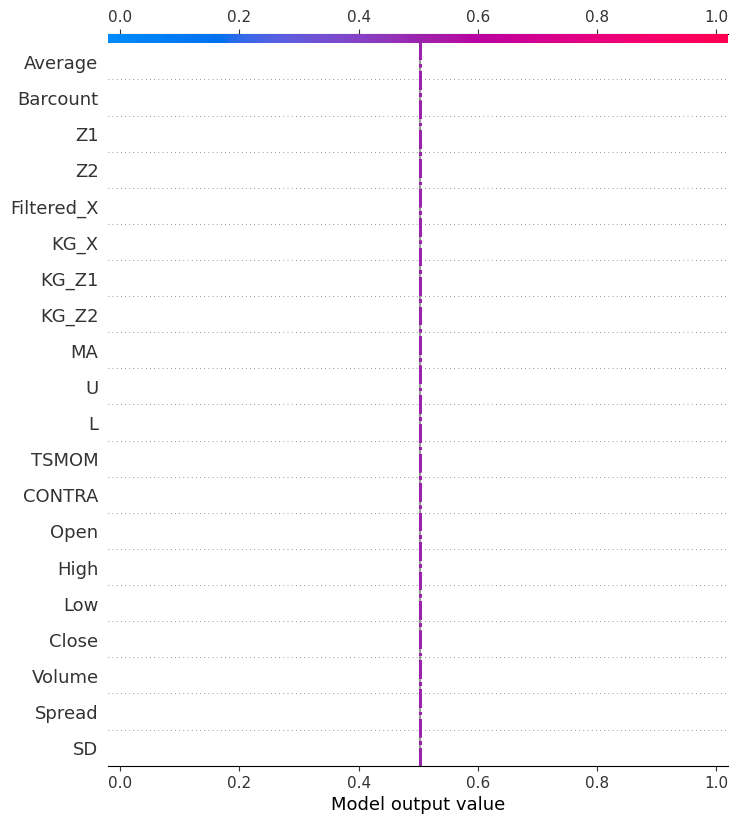

In [30]:
sample_index = 2
e = shap.KernelExplainer(model, background)

select = range(20)
shap_features = test_features[select]
train_features = background_features[select]
shap_values = e.shap_values(shap_features, nsamples=SAMPLE_SIZE)
print(f"SHAP values shape: {shap_values.shape}")

if isinstance(shap_values, list):
    shap_values = shap_values[0: SAMPLE_SIZE]
shap_values = np.squeeze(shap_values)
y_pred = (shap_values.sum(1) + e.expected_value) > 0
misclassified = y_pred != test_labels[select]
print(f"Misclassified: {np.shape(misclassified)} out of {np.shape(y_pred)[0]}")

print(f"Explainer expected value: {e.expected_value}")
shap.decision_plot(e.expected_value, shap_values, train_features, feature_names=FEATURES, link='logit', highlight=misclassified[0])

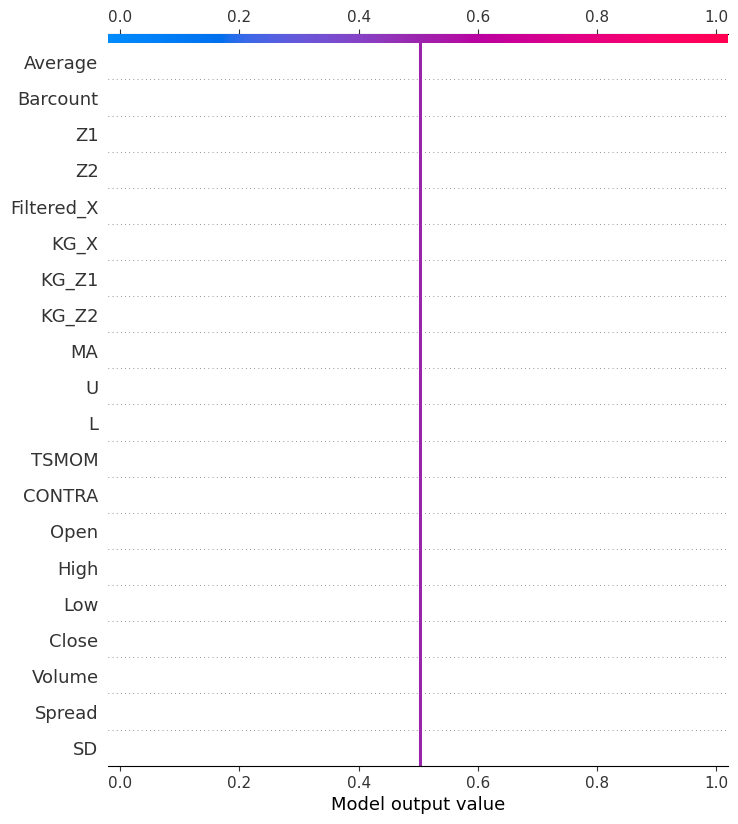

In [31]:
shap.decision_plot(
    e.expected_value,
    shap_values[misclassified],
    train_features[misclassified],
    link="logit",
    highlight=0,
    feature_names=FEATURES
)

In [32]:
shap.force_plot(
    e.expected_value,
    shap_values[misclassified],
    train_features[misclassified],
    link="logit",
    feature_names=FEATURES
)

## Metrics

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score

def print_metrics():
    ypred_raw = model.predict([X_t])
    pred = (ypred_raw > 0.5).astype(int)
    metrics = {}

    metrics = {
        "Accuracy": accuracy_score(y_t.flatten(), pred.flatten()),
        "Precision": precision_score(y_t.flatten(), pred.flatten()),
        "Recall": recall_score(y_t.flatten(), pred.flatten()),
        "F1b Score": fbeta_score(y_t.flatten(), pred.flatten(), average="weighted", beta=0.1),
        "ROC AUC": roc_auc_score(y_t.flatten(), ypred_raw.flatten(), average='weighted')  # Using raw probabilities
    }

    metrics_unseen_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_unseen_df

In [34]:
from tensorflow.math import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y, pred):
    cm = confusion_matrix(y.flatten(), pred)

    plt.figure(figsize=(8 if cm2 is not None else 4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)

    df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in labels], columns=[i for i in labels])
    cm_plot1 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels).get_figure()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix 1')
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()

    return cm_plot1

# Grid Search

In [35]:
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from tensorboard.plugins.hparams import api as hp

import json

HP_KERNEL_SIZE = hp.HParam("kernel_size", hp.Discrete([KERNEL_SIZE * 2, KERNEL_SIZE]))
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam("dilation_rate", hp.Discrete([DILATION_RATE]))
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE, DROPRATE*2]))
HP_REG_WEIGHTS = hp.HParam("reg_weight", hp.Discrete([REG_WEIGHTS, REG_WEIGHTS*2]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATTE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))
HP_HIDDEN_DENSE = hp.HParam("dense_units", hp.Discrete([
    f"{WINDOW}",
    f"{WINDOW*2}_{WINDOW}",
    f"{WINDOW*2}_{WINDOW}_{WINDOW//2}",
    f"{WINDOW*4}_{WINDOW*2}",
]))
HP_FILTERS = hp.HParam("filters", hp.Discrete([FILTERS //2 ,FILTERS, FILTERS * 2]))
HPARAMS = [
    HP_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_REG_WEIGHTS,
    HP_LEARNING_RATE,
    HP_PATIENCE,
    HP_HIDDEN_DENSE
    ]

def grid_search_build_cnn(input_shape, X, y, Xt=None, yt=None, hparams=HPARAMS, file_name=f"best_params.json", checkpoint_file = f"checkpoint.json"):
    def _decode_arrays(config_str):
        return [int(unit) for unit in config_str.split('_')]

    def _save_best_params(best_params, best_loss, best_metric, other_metrics = None, file_name="best_params.json"):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss, "best_metric": best_metric, 'other_metrics': other_metrics}, file)

    def _load_checkpoint(file_name):
        json = None
        try:
            os.makedirs(MODEL_DIR, exist_ok=True)
            with open(f"{MODEL_DIR}/{file_name}", "r") as file:
                json = json.load(file)
        except Exception as e:
            print(f"File {MODEL_DIR}/{file_name} not found or error {e}")
        return json

    def _save_checkpoint(state, file_name):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump(state, file)

    with create_file_writer(f"{LOG_BASEPATH}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )

    start_index = 0
    best_loss = np.inf
    best_metric = -np.inf
    best_params = None
    checkpoint = _load_checkpoint(checkpoint_file)
    if checkpoint:
        start_index = checkpoint['next_index']
        best_loss = checkpoint['best_loss']
        best_metric = checkpoint['best_metric']
        best_params = checkpoint['best_params']

    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    for index, hp_values in enumerate(tqdm(grid[start_index:], desc="Grid Search.."), start=start_index):
        dense_units = _decode_arrays(hp_values["dense_units"])
        filters = _decode_arrays(hp_values["filters"])
        b = hp_values["bias"]
        k = hp_values["kernel_size"]
        d = hp_values["dilation_rate"]
        rw = hp_values["reg_weight"]
        drop = hp_values["dropout_rate"]

        ERROR_ALPHA = hp_values["alpha"]
        ERROR_GAMMA = hp_values["gamma"]
        print(f"Shapes{input_shape}: x{X[0].shape}xg{X[1].shape}y{y.shape}, filters {filters}, dense {dense_units}, k: {k}, d: {d}, rw: {rw}, drop: {drop}, b: {b}, alpha: {ERROR_ALPHA},  gamma: {ERROR_GAMMA}")

        model, history = build_cnn(input_shape, X, y,
                                    Xt=Xt, yt=yt,
                                    filters=filters,
                                    kernel_size=k,
                                    b_cv=True)
        loss = history.history[f"val_loss"][-1]
        metric = history.history[f"val_{TARGET_METRIC}"][-1]
        if (metric > best_metric):
            best_history = history
            best_loss = loss
            best_metric = metric
            best_model = model
            best_params = hp_values
            other_metrics = {
                f"{TARGET_METRIC}": history.history[f"{TARGET_METRIC}"][-1],
                f"v_{TARGET_METRIC}": history.history[f"val_{TARGET_METRIC}"][-1],
                'ba': history.history["ba"][-1],
                'v_ba': history.history["val_ba"][-1],
            }
            _save_best_params(best_params, best_loss, best_metric, other_metrics, file_name)
        checkpoint_state = {
            'next_index': index + 1,
            'best_loss': best_loss,
            'best_metric': best_metric,
            'best_params': best_params
        }
        _save_checkpoint(checkpoint_state, checkpoint_file)
    return best_model, best_history, best_params, best_loss, best_metric

PARAM_SEARCH = False
if PARAM_SEARCH:
    with strategy.scope():
        assert not np.any(pd.isna(X)) and not np.any(np.isnan(X_t))
        print(f"{X.shape}")
        input_shape = (
            WINDOW,
            1 if len(X.shape) < 3 else X.shape[2],
        )

        model, history, best_params, best_loss, best_metric = grid_search_build_cnn(input_shape, X=X, y=y, Xt=X_t, yt=y_t, hparams=HPARAMS)
        print(best_params)
        print(best_metric)

# CV

In [36]:
from sklearn.model_selection import TimeSeriesSplit

CV_MODEL = True
CV_SPLITS = 3

def train_cv_model(X, y, input_shape, n_splits=5, perturb=True, window=WINDOW):
    def _perturb_gaussiannoise(X, noise_level=0.1):
        sigma = noise_level * np.std(X)
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

    if perturb:
        X = _perturb_gaussiannoise(X)

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    global metrics_col
    metrics_col = None

    for train_index, test_index in tqdm(tscv.split(X), desc=f"CV Testing for n_splits: {n_splits}"):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        X_train_windows, y_train_windows = prepare_windows(X_train, y_train, window_size=window)
        X_test_windows, y_test_windows = prepare_windows(X_test, y_test, window_size=window)

        try:
            cv_model, _ = build_cnn(input_shape, X=X_train_windows, y=y_train_windows, Xt=X_test_windows, yt=y_test_windows)

            result = cv_model.evaluate([X_test_windows], y_test_windows, verbose=0)
            results.append(result)

            if metrics_col is None:
                metrics_col = cv_model.metrics
        except Exception as e:
            print(f"CV error on fold with exception: {e}")

    if metrics_col is None:
        raise ValueError("No successful model training; metrics_col is None")

    metrics_names = [metric.name for metric in metrics_col]
    results_df = pd.DataFrame(results, columns=metrics_names)

    return results_df

# results_df = train_cv_model(train_ts_df.drop(columns=[META_LABEL]), train_ts_df[META_LABEL], input_shape)
# results_df